In [47]:
#Import Libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [51]:
#Load and Inspect Dataset

In [53]:
data = pd.read_csv('data/creditcard.csv')

In [54]:
# Basic exploration
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

   

In [55]:
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64


In [56]:
print("\n Null value check:")
print(data.isnull().sum())


 Null value check:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [59]:
print("\n Class distribution:")
print(data['Class'].value_counts())


 Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


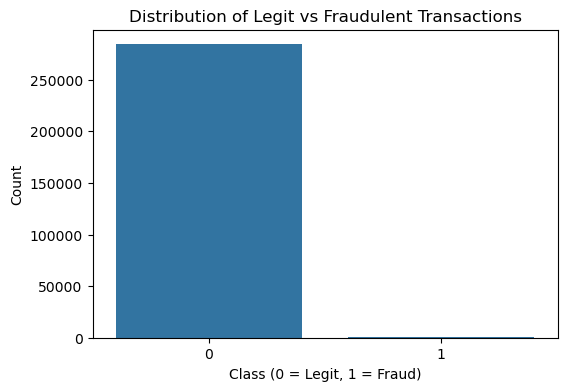

In [63]:
# Plotting the class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data)
plt.title('Distribution of Legit vs Fraudulent Transactions')
plt.xlabel('Class (0 = Legit, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

In [65]:
#Preprocessing

In [67]:
data = data.drop(columns=['Time'])

scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

In [69]:
 #Separate normal and fraud transactions

In [71]:
data_normal = data[data['Class'] == 0]
data_fraud = data[data['Class'] == 1]

X_normal = data_normal.drop(columns=['Class'])
X_fraud = data_fraud.drop(columns=['Class'])

In [73]:
#Train-Test Split (only normal for training)

In [75]:
# Scale all features
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_fraud_scaled = scaler.transform(X_fraud)

# Split normal data into train/test
X_train, X_test_normal = train_test_split(
    X_normal_scaled, test_size=0.2, random_state=42
)

# Combine test data (normal + fraud)
X_test = np.vstack([X_test_normal, X_fraud_scaled])
y_test = np.hstack([
    np.zeros(len(X_test_normal)),
    np.ones(len(X_fraud_scaled))
])

# Output shapes
print(f"\nTrain normal samples shape: {X_train.shape}")
print(f"Test set shape (normal + fraud): {X_test.shape}")


Train normal samples shape: (227452, 29)
Test set shape (normal + fraud): (57355, 29)


In [77]:
#Build Autoencoder Model

In [79]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
bottleneck = Dense(4, activation='relu')(encoded)

# Decoder
decoded = Dense(8, activation='relu')(bottleneck)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 29)                  │             957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,345 (13.07 KB)

 Trainable params: 3,345 (13.07 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
#Train Autoencoder

In [83]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/autoencoder_creditcard_model.keras', save_best_only=True, monitor='val_loss')

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

Epoch 1/100
711/711 - 14s - 20ms/step - loss: 0.8494 - val_loss: 0.7651
Epoch 2/100
711/711 - 2s - 3ms/step - loss: 0.6791 - val_loss: 0.6434
Epoch 3/100
711/711 - 2s - 3ms/step - loss: 0.6096 - val_loss: 0.6071
Epoch 4/100
711/711 - 2s - 3ms/step - loss: 0.5817 - val_loss: 0.5819
Epoch 5/100
711/711 - 2s - 3ms/step - loss: 0.5566 - val_loss: 0.5549
Epoch 6/100
711/711 - 2s - 3ms/step - loss: 0.5395 - val_loss: 0.5389
Epoch 7/100
711/711 - 2s - 3ms/step - loss: 0.5262 - val_loss: 0.5264
Epoch 8/100
711/711 - 2s - 3ms/step - loss: 0.5145 - val_loss: 0.5172
Epoch 9/100
711/711 - 2s - 3ms/step - loss: 0.5113 - val_loss: 0.5081
Epoch 10/100
711/711 - 3s - 4ms/step - loss: 0.4985 - val_loss: 0.5065
Epoch 11/100
711/711 - 2s - 3ms/step - loss: 0.4940 - val_loss: 0.4974
Epoch 12/100
711/711 - 3s - 4ms/step - loss: 0.4895 - val_loss: 0.4929
Epoch 13/100
711/711 - 3s - 4ms/step - loss: 0.4862 - val_loss: 0.4887
Epoch 14/100
711/711 - 3s - 4ms/step - loss: 0.4822 - val_loss: 0.4868
Epoch 15/100


In [85]:
#Plot Training Loss

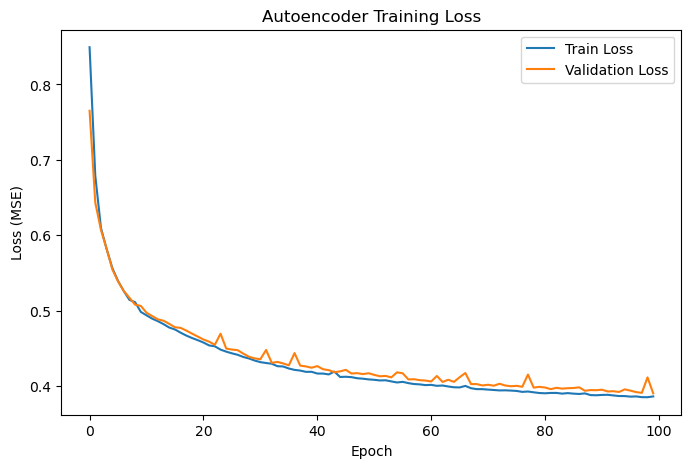

In [87]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [89]:
#Calculate Reconstruction Errors on Test Set

In [91]:
X_test_pred = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [ ]:
#Determine Threshold

In [93]:
X_train_pred = autoencoder.predict(X_train)
train_errors = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
threshold = np.percentile(train_errors, 95)
print(f"\n Reconstruction error threshold (95th percentile): {threshold:.6f}")

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

 Reconstruction error threshold (95th percentile): 0.977389


In [ ]:
#Plot Reconstruction Error Distribution

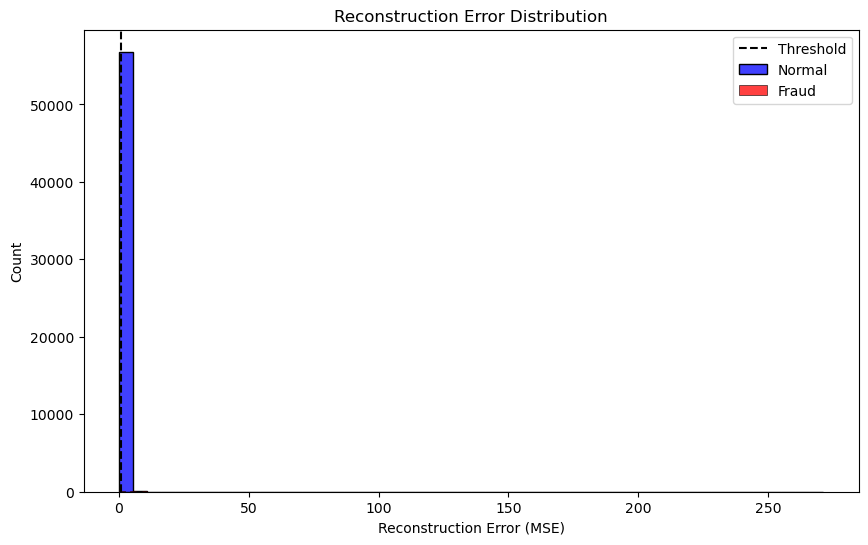

In [95]:
plt.figure(figsize=(10,6))
sns.histplot(reconstruction_errors[y_test == 0], bins=50, color='blue', label='Normal')
sns.histplot(reconstruction_errors[y_test == 1], bins=50, color='red', label='Fraud')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [97]:
#Make Predictions Based on Threshold

In [99]:
y_pred = (reconstruction_errors > threshold).astype(int)

In [101]:
#Evaluate Model Performance

In [105]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, reconstruction_errors)
cm = confusion_matrix(y_test, y_pred)

print("\n Evaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print("Confusion Matrix:\n", cm)


 Evaluation Metrics:
Precision: 0.1267
Recall:    0.8516
F1 Score:  0.2205
ROC AUC:   0.9472
Confusion Matrix:
 [[53974  2889]
 [   73   419]]
